In [1]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")


# Compare Reward Components from Training Logs

This notebook analyzes and visualizes reward components from PPO training logs.

Features:
- Load and parse JSON training logs (episode_summary.jsonl, reward_analysis.jsonl)
- Compare different reward components over time  
- Visualize training progress
- Compare multiple training runs


## Select Training Run

Choose which training run to analyze.


In [ ]:
# Path to results directory with training logs
results_dir = 'results'

# Find all training runs (directories with episode_summary.jsonl)
all_dirs = sorted([d for d in glob.glob(os.path.join(results_dir, '*')) 
                   if os.path.isdir(d)])

training_runs = []
for d in all_dirs:
    episode_file = os.path.join(d, 'episode_summary.jsonl')
    if os.path.exists(episode_file) and os.path.getsize(episode_file) > 0:
        training_runs.append(d)

if training_runs:
    print(f" Found {len(training_runs)} training runs with data:")
    
    # Show first 10 and last 10
    if len(training_runs) <= 20:
        for i, run in enumerate(training_runs):
            size = os.path.getsize(os.path.join(run, 'episode_summary.jsonl'))
            print(f"  {i}: {os.path.basename(run):30s} ({size/1024:.1f} KB)")
    else:
        for i in range(10):
            run = training_runs[i]
            size = os.path.getsize(os.path.join(run, 'episode_summary.jsonl'))
            print(f"  {i}: {os.path.basename(run):30s} ({size/1024:.1f} KB)")
        print(f"  ... {len(training_runs) - 20} more runs ...")
        for i in range(len(training_runs) - 10, len(training_runs)):
            run = training_runs[i]
            size = os.path.getsize(os.path.join(run, 'episode_summary.jsonl'))
            print(f"  {i}: {os.path.basename(run):30s} ({size/1024:.1f} KB)")
    
    # Use the latest run
    selected_run = training_runs[-1]
    print(f"\n Selected: {os.path.basename(selected_run)}")
else:
    print("  No training runs found in 'results/' directory")
    print("   Make sure training runs have 'episode_summary.jsonl' files")
    selected_run = None


✅ Found 161 training runs with data:
  0: 0211-14:24                     (1413.7 KB)
  1: 0211-16:34                     (1400.5 KB)
  2: 0211-19:19                     (1417.9 KB)
  3: 0211-20:50                     (1387.0 KB)
  4: 0311-11:26                     (1177.2 KB)
  5: 0311-13:34                     (1190.0 KB)
  6: 0311-16:31                     (1176.8 KB)
  7: 0311-17:33                     (1166.3 KB)
  8: 0311-19:19                     (1160.3 KB)
  9: 0311-21:12                     (1162.0 KB)
  ... 141 more runs ...
  151: master_decay_training_20250902_160501 (1014.2 KB)
  152: master_decay_training_20250911_165522 (582.4 KB)
  153: master_decay_training_20250915_161420 (808.3 KB)
  154: master_decay_training_20250915_165554 (547.0 KB)
  155: master_exact_architecture_20250901_185530_20250901_185535 (159.9 KB)
  156: optimal_170ep_parametric_softmax_20250901_133953 (154.3 KB)
  157: small_training_1000_steps      (824.4 KB)
  158: train_ipdate-1009-18:29        (573

## Load Training Data


In [3]:
def load_episode_data(run_path):
    """Load episode summary data from a training run."""
    episode_file = os.path.join(run_path, 'episode_summary.jsonl')
    
    if not os.path.exists(episode_file):
        return None
    
    episodes = []
    with open(episode_file, 'r') as f:
        for line in f:
            if line.strip():
                episodes.append(json.loads(line))
    
    return pd.DataFrame(episodes)

if selected_run:
    print(f"Loading data from: {os.path.basename(selected_run)}")
    df = load_episode_data(selected_run)
    
    if df is not None and len(df) > 0:
        print(f"\n Loaded {len(df)} episodes")
        print(f"\nAvailable columns:")
        for col in df.columns:
            print(f"   - {col}")
        
        print(f"\nData summary:")
        print(f"   Total episodes: {len(df)}")
        if 'total_reward' in df.columns:
            print(f"   Mean reward: {df['total_reward'].mean():.2f}")
            print(f"   Max reward: {df['total_reward'].max():.2f}")
            print(f"   Min reward: {df['total_reward'].min():.2f}")
        if 'steps' in df.columns:
            print(f"   Mean steps: {df['steps'].mean():.2f}")
        
        logs_loaded = True
    else:
        print("  No data found in episode summary file")
        logs_loaded = False
else:
    logs_loaded = False


Loading data from: with-decay-enabled

📊 Loaded 22 episodes

Available columns:
   - episode
   - total_reward
   - reward_without_humanity
   - step
   - timestamp
   - reward_summary
   - action_types

Data summary:
   Total episodes: 22
   Mean reward: 1.63
   Max reward: 7.90
   Min reward: -2.29


## Plot Training Progress


/var/folders/nq/v_7l2dgx4m301tz6hhh7wz7h0000gn/T/ipykernel_82457/4075242051.py:82: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


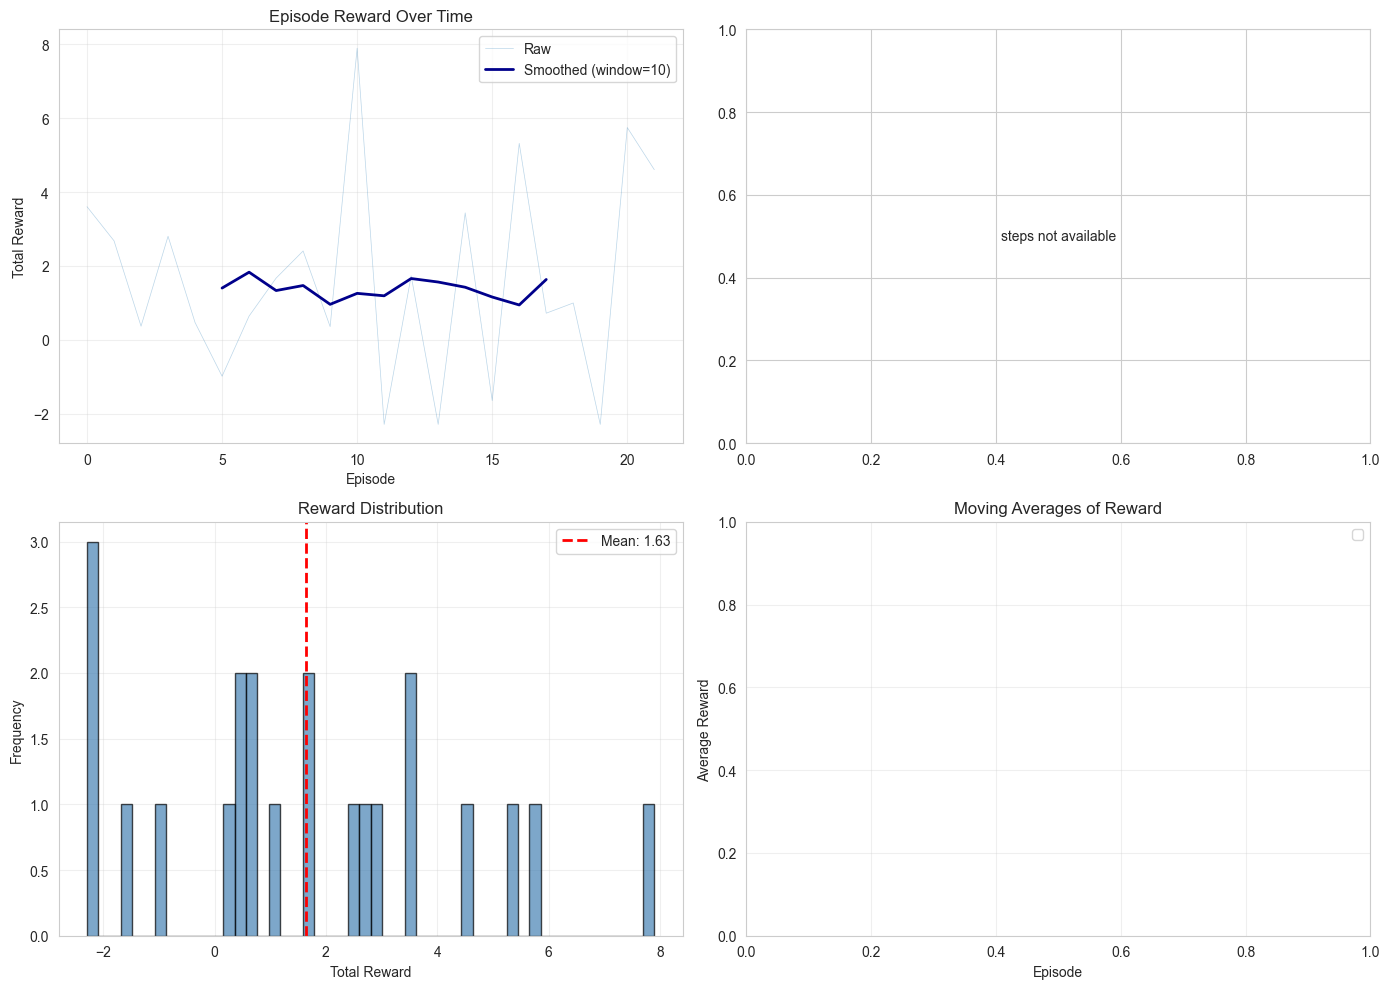

In [4]:
if logs_loaded and df is not None:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Episode Reward
    ax = axes[0, 0]
    if 'total_reward' in df.columns:
        episodes = np.arange(len(df))
        rewards = df['total_reward'].values
        
        # Raw rewards
        ax.plot(episodes, rewards, alpha=0.3, label='Raw', linewidth=0.5)
        
        # Smoothed rewards
        if len(rewards) > 10:
            window = min(100, max(10, len(rewards) // 20))
            smoothed = pd.Series(rewards).rolling(window=window, center=True).mean()
            ax.plot(episodes, smoothed, linewidth=2, label=f'Smoothed (window={window})', color='darkblue')
        
        ax.set_xlabel('Episode')
        ax.set_ylabel('Total Reward')
        ax.set_title('Episode Reward Over Time')
        ax.legend()
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'total_reward not available', 
               ha='center', va='center', transform=ax.transAxes)
    
    # Plot 2: Episode Length
    ax = axes[0, 1]
    if 'steps' in df.columns:
        episodes = np.arange(len(df))
        steps = df['steps'].values
        
        ax.plot(episodes, steps, alpha=0.3, linewidth=0.5)
        
        if len(steps) > 10:
            window = min(100, max(10, len(steps) // 20))
            smoothed = pd.Series(steps).rolling(window=window, center=True).mean()
            ax.plot(episodes, smoothed, linewidth=2, color='darkgreen')
        
        ax.set_xlabel('Episode')
        ax.set_ylabel('Steps')
        ax.set_title('Episode Length Over Time')
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'steps not available', 
               ha='center', va='center', transform=ax.transAxes)
    
    # Plot 3: Reward Distribution
    ax = axes[1, 0]
    if 'total_reward' in df.columns:
        ax.hist(df['total_reward'], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
        ax.axvline(df['total_reward'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {df["total_reward"].mean():.2f}')
        ax.set_xlabel('Total Reward')
        ax.set_ylabel('Frequency')
        ax.set_title('Reward Distribution')
        ax.legend()
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'total_reward not available', 
               ha='center', va='center', transform=ax.transAxes)
    
    # Plot 4: Moving Average of Reward
    ax = axes[1, 1]
    if 'total_reward' in df.columns:
        episodes = np.arange(len(df))
        rewards = df['total_reward'].values
        
        # Multiple window sizes
        windows = [50, 100, 200]
        colors = ['lightblue', 'blue', 'darkblue']
        
        for window, color in zip(windows, colors):
            if len(rewards) >= window:
                smoothed = pd.Series(rewards).rolling(window=window, center=True).mean()
                ax.plot(episodes, smoothed, linewidth=2, label=f'{window}-ep MA', color=color)
        
        ax.set_xlabel('Episode')
        ax.set_ylabel('Average Reward')
        ax.set_title('Moving Averages of Reward')
        ax.legend()
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'total_reward not available', 
               ha='center', va='center', transform=ax.transAxes)
    
    plt.tight_layout()
    plt.show()
else:
    print("Cannot plot - no logs available")


## Analyze Action Types



📊 Action Type Analysis


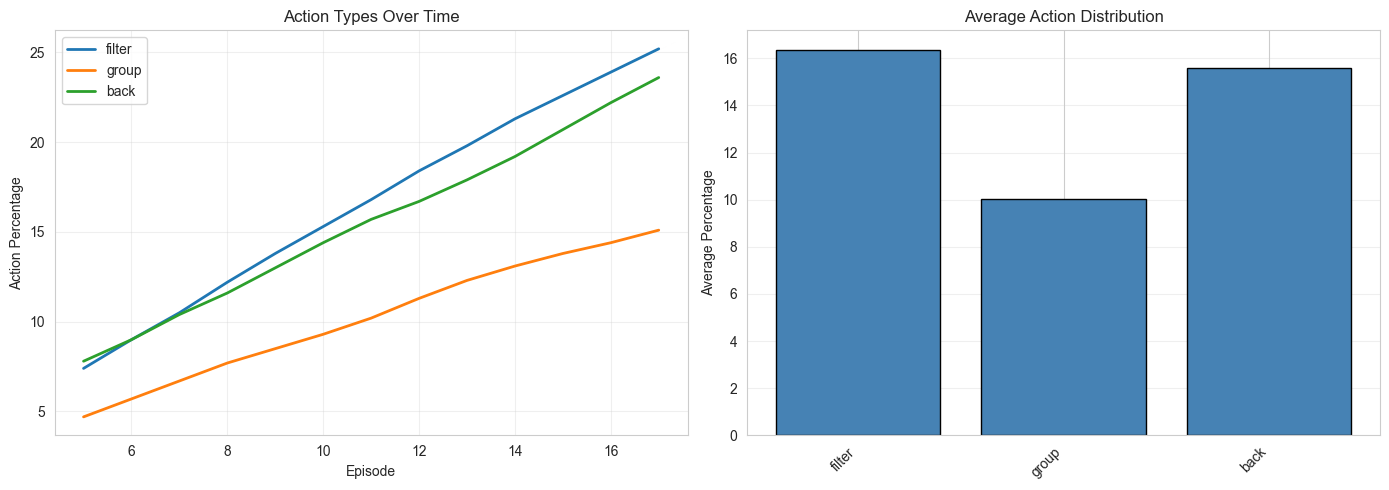


Average action distribution:
  filter: 16.36%
  group: 10.05%
  back: 15.59%


In [5]:
if logs_loaded and df is not None and 'action_types' in df.columns:
    print("\n Action Type Analysis")
    
    # Extract action type data
    action_data = []
    for idx, row in df.iterrows():
        if isinstance(row['action_types'], dict):
            episode_actions = {'episode': idx}
            episode_actions.update(row['action_types'])
            action_data.append(episode_actions)
    
    if action_data:
        action_df = pd.DataFrame(action_data)
        action_cols = [col for col in action_df.columns if col != 'episode']
        
        # Plot action types over time
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Line plot over time
        ax = axes[0]
        if action_cols:
            for col in action_cols:
                if col in action_df.columns:
                    window = min(100, max(10, len(action_df) // 20))
                    smoothed = action_df[col].rolling(window=window, center=True).mean()
                    ax.plot(action_df['episode'], smoothed, label=col, linewidth=2)
            
            ax.set_xlabel('Episode')
            ax.set_ylabel('Action Percentage')
            ax.set_title('Action Types Over Time')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # Average distribution
        ax = axes[1]
        if action_cols:
            avg_actions = {col: action_df[col].mean() for col in action_cols if col in action_df.columns}
            ax.bar(avg_actions.keys(), avg_actions.values(), color='steelblue', edgecolor='black')
            ax.set_ylabel('Average Percentage')
            ax.set_title('Average Action Distribution')
            ax.grid(True, alpha=0.3, axis='y')
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
        
        print("\nAverage action distribution:")
        for col in action_cols:
            if col in action_df.columns:
                print(f"  {col}: {action_df[col].mean():.2f}%")
    else:
        print("No action type data available")
else:
    print("Action type data not available")


## Compare Multiple Training Runs

Compare different training runs side by side.


Comparing 5 most recent training runs...

  optimal_170ep_parametric_softmax_20250901_133953 -    170 episodes, avg reward:   11.46
  small_training_1000_steps      -    812 episodes, avg reward:    0.31
  train_ipdate-1009-18:29        -    583 episodes, avg reward:   11.05
  train_ipdate-1009-18:35        -    585 episodes, avg reward:    2.15
  with-decay-enabled             -     22 episodes, avg reward:    1.63


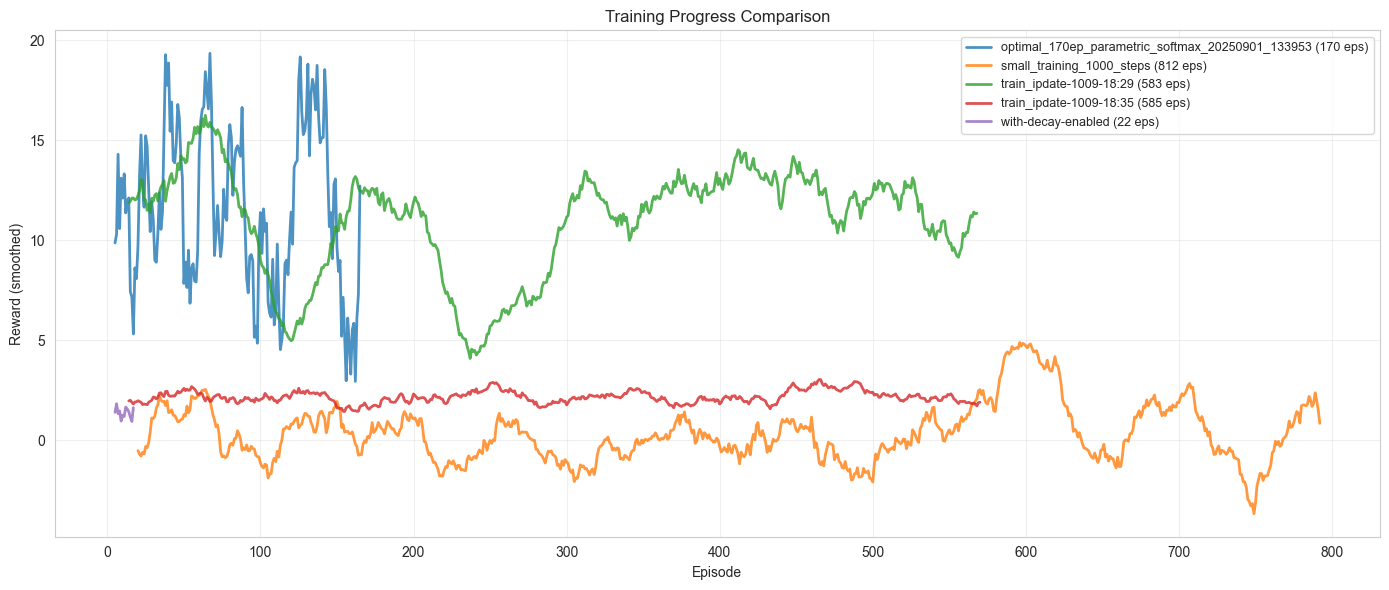

In [6]:
# Select which runs to compare (by default, show the 5 most recent)
n_runs_to_compare = min(5, len(training_runs))
runs_to_compare = training_runs[-n_runs_to_compare:]

print(f"Comparing {len(runs_to_compare)} most recent training runs...\n")

if runs_to_compare and len(runs_to_compare) > 1:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    for run_path in runs_to_compare:
        run_name = os.path.basename(run_path)
        run_df = load_episode_data(run_path)
        
        if run_df is not None and 'total_reward' in run_df.columns and len(run_df) > 0:
            episodes = np.arange(len(run_df))
            rewards = run_df['total_reward'].values
            
            # Smoothed plot
            if len(rewards) > 10:
                window = min(100, max(10, len(rewards) // 20))
                smoothed = pd.Series(rewards).rolling(window=window, center=True).mean()
                ax.plot(episodes, smoothed, label=f"{run_name} ({len(run_df)} eps)", linewidth=2, alpha=0.8)
                print(f"  {run_name:30s} - {len(run_df):6d} episodes, avg reward: {rewards.mean():7.2f}")
    
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward (smoothed)')
    ax.set_title('Training Progress Comparison')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
elif len(runs_to_compare) == 1:
    print("Only one training run available - nothing to compare")
else:
    print("No training runs available for comparison")


## Detailed Reward Component Analysis

Analyze specific reward components from detailed logs (reward_analysis.jsonl).


In [ ]:
if selected_run:
    reward_file = os.path.join(selected_run, 'reward_analysis.jsonl')
    
    if os.path.exists(reward_file):
        print(f"Loading detailed reward data from first 10,000 steps...")
        
        # Load a sample of reward data (first 10000 steps to avoid memory issues)
        reward_data = []
        with open(reward_file, 'r') as f:
            for i, line in enumerate(f):
                if i >= 10000:  # Limit to first 10k steps
                    break
                if line.strip():
                    reward_data.append(json.loads(line))
        
        if reward_data:
            reward_df = pd.DataFrame(reward_data)
            print(f"Loaded {len(reward_df)} steps of detailed data")
            
            # Extract reward breakdown components
            if 'reward_breakdown' in reward_df.columns:
                breakdown_data = []
                for idx, row in reward_df.iterrows():
                    if isinstance(row['reward_breakdown'], dict) and row['reward_breakdown']:
                        step_breakdown = {'step': row.get('step', idx)}
                        step_breakdown.update(row['reward_breakdown'])
                        breakdown_data.append(step_breakdown)
                
                if breakdown_data:
                    breakdown_df = pd.DataFrame(breakdown_data)
                    
                    # Plot key reward components
                    component_cols = ['diversity', 'interestingness', 'humanity', 
                                     'kl_distance', 'compaction_gain']
                    available_cols = [col for col in component_cols if col in breakdown_df.columns]
                    
                    if available_cols:
                        n_cols = len(available_cols)
                        fig, axes = plt.subplots(n_cols, 1, figsize=(14, 3*n_cols))
                        if n_cols == 1:
                            axes = [axes]
                        
                        for ax, col in zip(axes, available_cols):
                            values = breakdown_df[col].values
                            steps = breakdown_df['step'].values
                            
                            ax.plot(steps, values, alpha=0.3, linewidth=0.5)
                            
                            if len(values) > 10:
                                window = min(100, max(10, len(values) // 20))
                                smoothed = pd.Series(values).rolling(window=window, center=True).mean()
                                ax.plot(steps, smoothed, linewidth=2, color='darkred')
                            
                            ax.set_xlabel('Step')
                            ax.set_ylabel(col.replace('_', ' ').title())
                            ax.set_title(f'{col.replace("_", " ").title()} Over Time')
                            ax.grid(True, alpha=0.3)
                        
                        plt.tight_layout()
                        plt.show()
                        
                        print("\nAverage reward components:")
                        for col in available_cols:
                            print(f"  {col:20s}: {breakdown_df[col].mean():8.4f}")
                    else:
                        print("No standard reward components found in breakdown")
                else:
                    print("No reward breakdown data available")
            else:
                print("No reward_breakdown column in detailed data")
        else:
            print("No data in reward analysis file")
    else:
        print("reward_analysis.jsonl not found in this run")
else:
    print("No run selected")


reward_analysis.jsonl not found in this run
